In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/netflix-stock-price/NFLX.csv


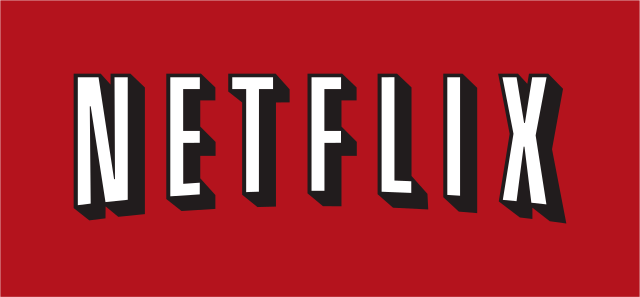

**Hello**

This notebook is about Netflix Stock Forecasting using **LSTM** 

Let's get started

# Importing Needed Libraries

In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import keras
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Reading The Data

In [3]:
df = pd.read_csv('/kaggle/input/netflix-stock-price/NFLX.csv', parse_dates= True , index_col= "Date")

In [4]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200


**About the Attributes**

**Date**: The date of the data point.

**Open**: The opening price of Netflix, Inc. stock on that date.

**High**: The highest price reached by Netflix stock during the trading day.

**Low**: The lowest price reached by Netflix stock during the trading day.

**Close**: The closing price of Netflix stock on that date.

**Adj Close**: The adjusted closing price of Netflix stock, accounting for events like dividends and stock splits.

**Volume**: The trading volume for Netflix stock on that date, representing the number of shares traded.

In [5]:
df.shape

(5422, 6)

# Data Exploration

In [6]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5422.000000,5422.000000,5422.000000,5422.000000,5422.000000,5.422000e+03
mean,131.304057,133.340057,129.201970,131.322955,131.322955,1.594455e+07
std,172.967612,175.451082,170.335958,172.929156,172.929156,1.874197e+07
min,0.377857,0.410714,0.346429,0.372857,0.372857,2.856000e+05
25%,4.107500,4.183214,4.031786,4.112857,4.112857,5.960725e+06
50%,33.700714,34.275714,33.237858,33.833570,33.833570,1.006250e+07
75%,244.832497,250.257496,237.687497,245.152500,245.152500,1.886930e+07
max,692.349976,700.989990,686.090027,691.690002,691.690002,3.234140e+08


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5422 entries, 2002-05-23 to 2023-12-05
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5422 non-null   float64
 1   High       5422 non-null   float64
 2   Low        5422 non-null   float64
 3   Close      5422 non-null   float64
 4   Adj Close  5422 non-null   float64
 5   Volume     5422 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 296.5 KB


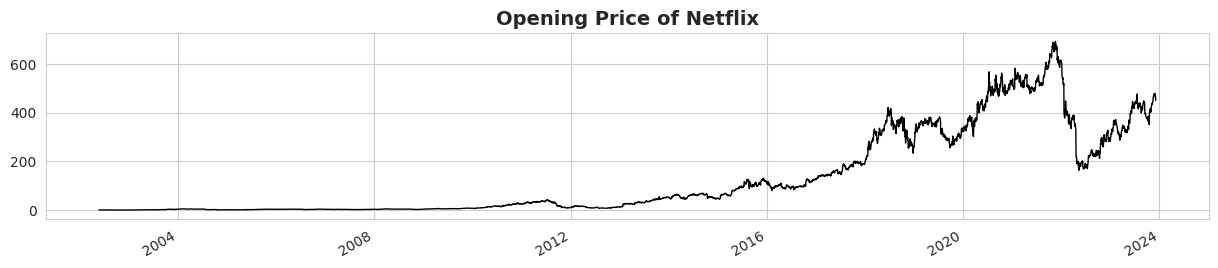

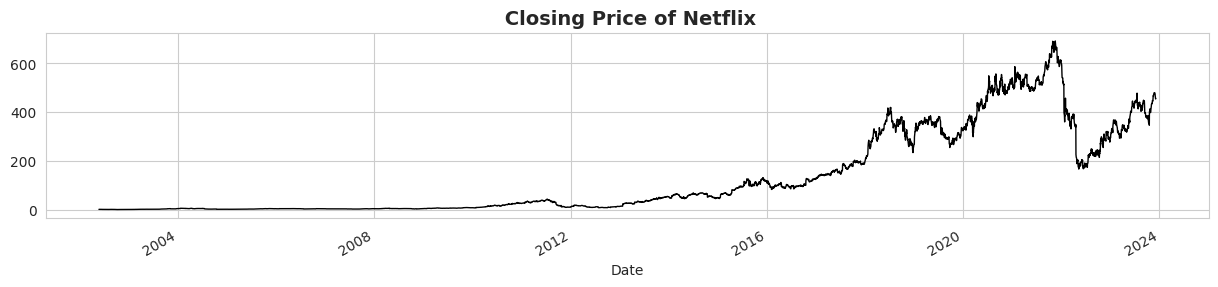

In [8]:
plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
df['Open'].plot(lw=1, color='black')
#df['Close'].plot(lw=1)
plt.ylabel(None)
plt.xlabel(None)
plt.title("Opening Price of Netflix", fontsize=14,fontweight='bold')
plt.show()

# 

plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 2)
df['Close'].plot(lw=1, color='black')
plt.title(" Closing Price of Netflix" ,fontsize=14,fontweight='bold')
plt.show()

**Netflix and COVID-19**

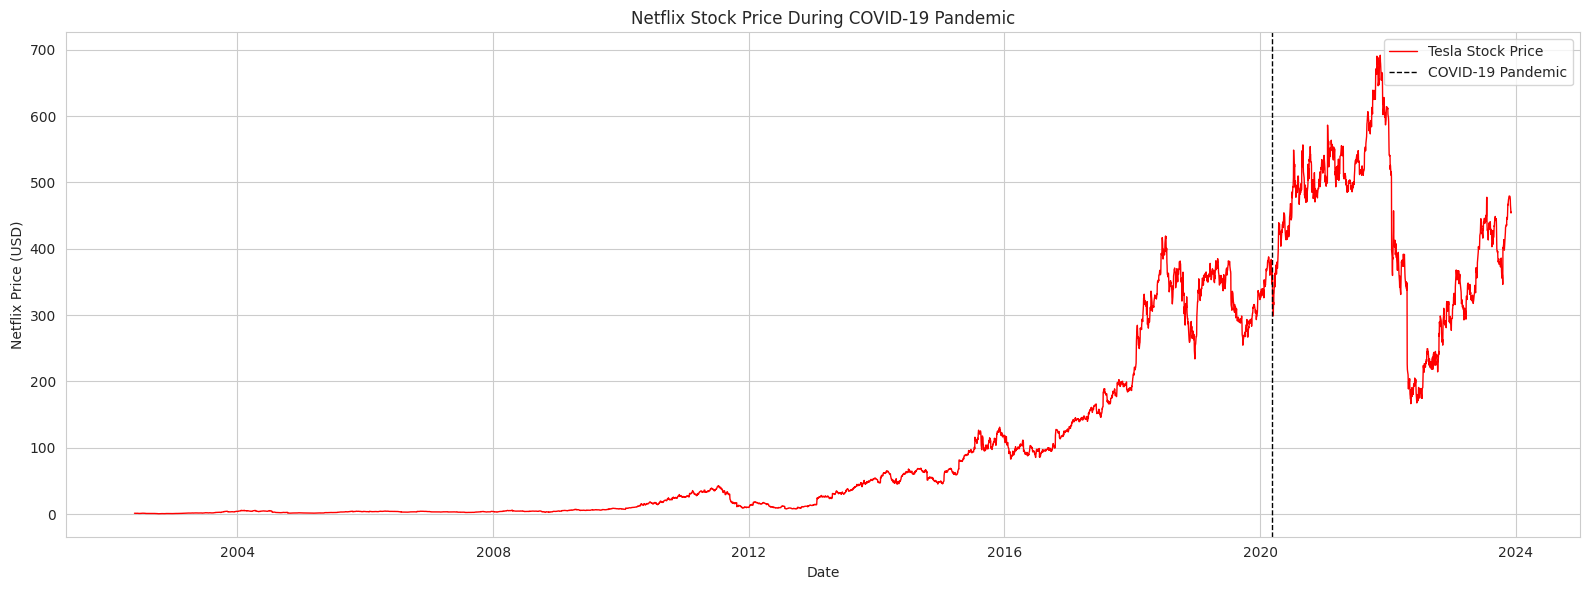

In [9]:
# Create a line plot showing Tesla's stock price around the time of the COVID-19 outbreak
plt.figure(figsize=(16,6))
plt.plot(df['Close'], label='Tesla Stock Price', color='red', lw=1)
plt.axvline(pd.to_datetime('2020-03-11'), color='black', linestyle='--', label='COVID-19 Pandemic', lw=1)
plt.title('Netflix Stock Price During COVID-19 Pandemic')
plt.xlabel('Date')
plt.ylabel('Netflix Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()

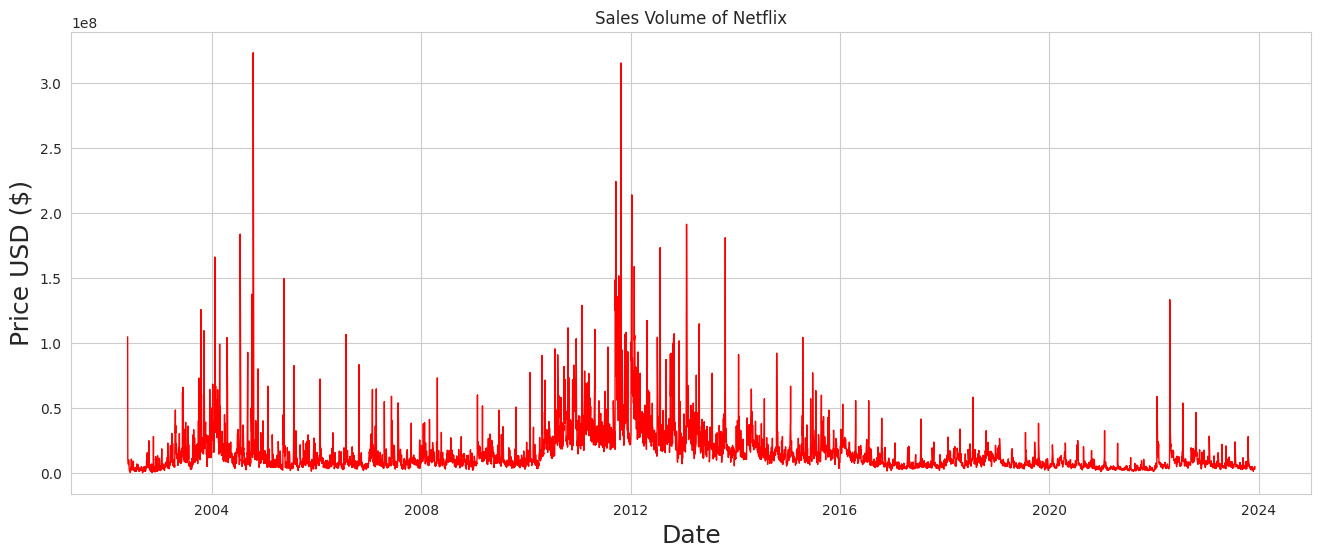

In [10]:
plt.figure(figsize=(16,6))
plt.plot( df['Volume'], lw = 1, color='red')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price USD ($)', fontsize=18)
plt.title('Sales Volume of Netflix')
plt.show()

# Data Preprocessing

Choosing Prediction Column

In [11]:
newdf = df["Close"]
newdf = pd.DataFrame(newdf)

data = newdf.values

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range= (0, 1))
scaled_data = scaler.fit_transform(np.array(data).reshape(-1, 1))

In [13]:
# 75% to Train , 25% to Test
train_size = int(len(data)*.75)
test_size = len(data) - train_size

print("Train Size :",train_size,"Test Size :",test_size)

train_data = scaled_data[ :train_size , 0:1 ]
test_data = scaled_data[ train_size-60: , 0:1 ]

Train Size : 4066 Test Size : 1356


In [14]:
train_data.shape, test_data.shape

((4066, 1), (1416, 1))

In [15]:
# Creating a Training set with 60 time-steps and 1 output
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [16]:
# Convert to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

In [17]:
# Reshaping the input
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [18]:
x_train.shape , y_train.shape

((4006, 60, 1), (4006,))

# LSTM Mode

In [19]:
model = Sequential([
    LSTM(50, return_sequences= True, input_shape= (x_train.shape[1], 1)),
    LSTM(64, return_sequences= False),
    Dense(32),
    Dense(16),
    Dense(1)
])

model.compile(optimizer= 'adam', loss= 'mse' , metrics= "mean_absolute_error")

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 42465 (165.88 KB)
Trainable params: 42465 (165.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
# Fitting the LSTM to the Training set
callbacks = [EarlyStopping(monitor= 'loss', patience= 10 , restore_best_weights= True)]
history = model.fit(x_train, y_train, epochs= 15, batch_size= 64 , callbacks= callbacks )

Epoch 1/15
63/63 [==============================] - 10s 71ms/step - loss: 6.9359e-04 - mean_absolute_error: 0.0147
Epoch 2/15
63/63 [==============================] - 5s 74ms/step - loss: 5.0710e-05 - mean_absolute_error: 0.0038
Epoch 3/15
63/63 [==============================] - 4s 70ms/step - loss: 5.0678e-05 - mean_absolute_error: 0.0039
Epoch 4/15
63/63 [==============================] - 4s 70ms/step - loss: 4.7912e-05 - mean_absolute_error: 0.0037
Epoch 5/15
63/63 [==============================] - 4s 68ms/step - loss: 4.8197e-05 - mean_absolute_error: 0.0037
Epoch 6/15
63/63 [==============================] - 5s 72ms/step - loss: 4.5906e-05 - mean_absolute_error: 0.0036
Epoch 7/15
63/63 [==============================] - 4s 70ms/step - loss: 4.1314e-05 - mean_absolute_error: 0.0033
Epoch 8/15
63/63 [==============================] - 4s 70ms/step - loss: 5.2001e-05 - mean_absolute_error: 0.0044
Epoch 9/15
63/63 [==============================] - 5s 76ms/step - loss: 4.3129e-05 - m

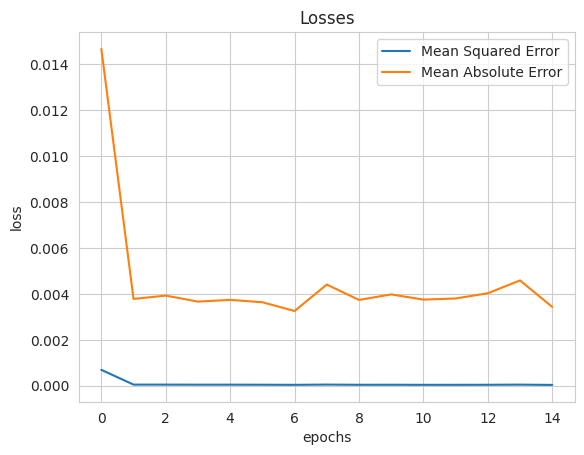

In [22]:
plt.plot(history.history["loss"])
plt.plot(history.history["mean_absolute_error"])
plt.legend(['Mean Squared Error','Mean Absolute Error'])
plt.title("Losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# Predection

In [23]:
# Creating a testing set with 60 time-steps and 1 output
x_test = []
y_test = []

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [24]:
#inverse y_test scaling
predictions = model.predict(x_test)

#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

43/43 [==============================] - 2s 19ms/step


(1356, 1)

In [25]:
#inverse y_test scaling
y_test = scaler.inverse_transform([y_test])

RMSE = np.sqrt(np.mean( y_test - predictions )**2).round(2)
RMSE

5.2

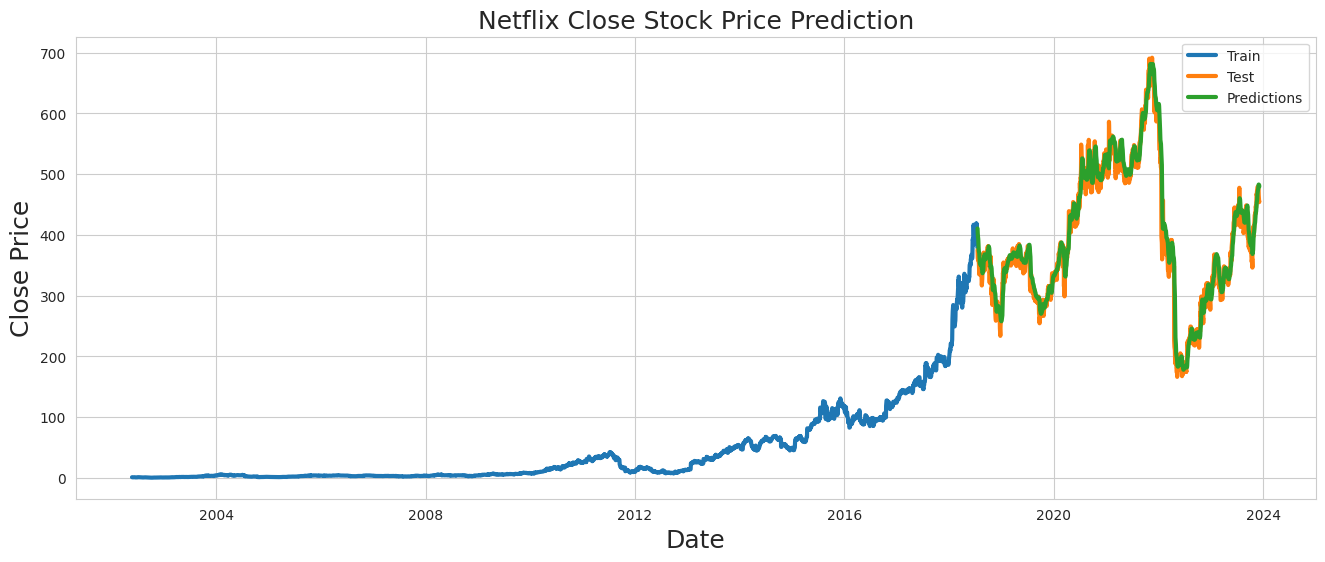

In [26]:
train = newdf.iloc[:train_size , 0:1]
test = newdf.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Netflix Close Stock Price Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Close Price', fontsize= 18)
plt.plot(train['Close'], linewidth= 3)
plt.plot(test['Close'], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])

# Forcasting for next month

In [27]:
from datetime import timedelta

In [28]:
def insert_end(Xin, new_input):
    timestep = 60
    for i in range(timestep - 1):
        Xin[:, i, :] = Xin[:, i+1, :]
    Xin[:, timestep - 1, :] = new_input
    return Xin

In [29]:
future = 30
forcast = []
Xin = x_test[-1 :, :, :]
time = []
for i in range(0, future):
    out = model.predict(Xin, batch_size=5)
    forcast.append(out[0, 0]) 
    print(forcast)
    Xin = insert_end(Xin, out[0, 0]) 
    time.append(pd.to_datetime(df.index[-1]) + timedelta(days=i))

1/1 [==============================] - 0s 32ms/step
[0.69314116]
1/1 [==============================] - 0s 33ms/step
[0.69314116, 0.6921065]
1/1 [==============================] - 0s 32ms/step
[0.69314116, 0.6921065, 0.69235575]
1/1 [==============================] - 0s 32ms/step
[0.69314116, 0.6921065, 0.69235575, 0.69336414]
1/1 [==============================] - 0s 32ms/step
[0.69314116, 0.6921065, 0.69235575, 0.69336414, 0.6948226]
1/1 [==============================] - 0s 32ms/step
[0.69314116, 0.6921065, 0.69235575, 0.69336414, 0.6948226, 0.6965529]
1/1 [==============================] - 0s 30ms/step
[0.69314116, 0.6921065, 0.69235575, 0.69336414, 0.6948226, 0.6965529, 0.6984505]
1/1 [==============================] - 0s 32ms/step
[0.69314116, 0.6921065, 0.69235575, 0.69336414, 0.6948226, 0.6965529, 0.6984505, 0.7004543]
1/1 [==============================] - 0s 33ms/step
[0.69314116, 0.6921065, 0.69235575, 0.69336414, 0.6948226, 0.6965529, 0.6984505, 0.7004543, 0.7025274]
1/1 [=

In [30]:
time

[Timestamp('2023-12-05 00:00:00'),
 Timestamp('2023-12-06 00:00:00'),
 Timestamp('2023-12-07 00:00:00'),
 Timestamp('2023-12-08 00:00:00'),
 Timestamp('2023-12-09 00:00:00'),
 Timestamp('2023-12-10 00:00:00'),
 Timestamp('2023-12-11 00:00:00'),
 Timestamp('2023-12-12 00:00:00'),
 Timestamp('2023-12-13 00:00:00'),
 Timestamp('2023-12-14 00:00:00'),
 Timestamp('2023-12-15 00:00:00'),
 Timestamp('2023-12-16 00:00:00'),
 Timestamp('2023-12-17 00:00:00'),
 Timestamp('2023-12-18 00:00:00'),
 Timestamp('2023-12-19 00:00:00'),
 Timestamp('2023-12-20 00:00:00'),
 Timestamp('2023-12-21 00:00:00'),
 Timestamp('2023-12-22 00:00:00'),
 Timestamp('2023-12-23 00:00:00'),
 Timestamp('2023-12-24 00:00:00'),
 Timestamp('2023-12-25 00:00:00'),
 Timestamp('2023-12-26 00:00:00'),
 Timestamp('2023-12-27 00:00:00'),
 Timestamp('2023-12-28 00:00:00'),
 Timestamp('2023-12-29 00:00:00'),
 Timestamp('2023-12-30 00:00:00'),
 Timestamp('2023-12-31 00:00:00'),
 Timestamp('2024-01-01 00:00:00'),
 Timestamp('2024-01-

In [31]:
forcasted_output = np.asanyarray(forcast)   
forcasted_output = forcasted_output.reshape(-1, 1) 
forcasted_output = scaler.inverse_transform(forcasted_output) 

In [32]:
forcasted_output = pd.DataFrame(forcasted_output)
date = pd.DataFrame(time)
df_result = pd.concat([date,forcasted_output], axis=1)
df_result.columns = "Date", "Forecasted"

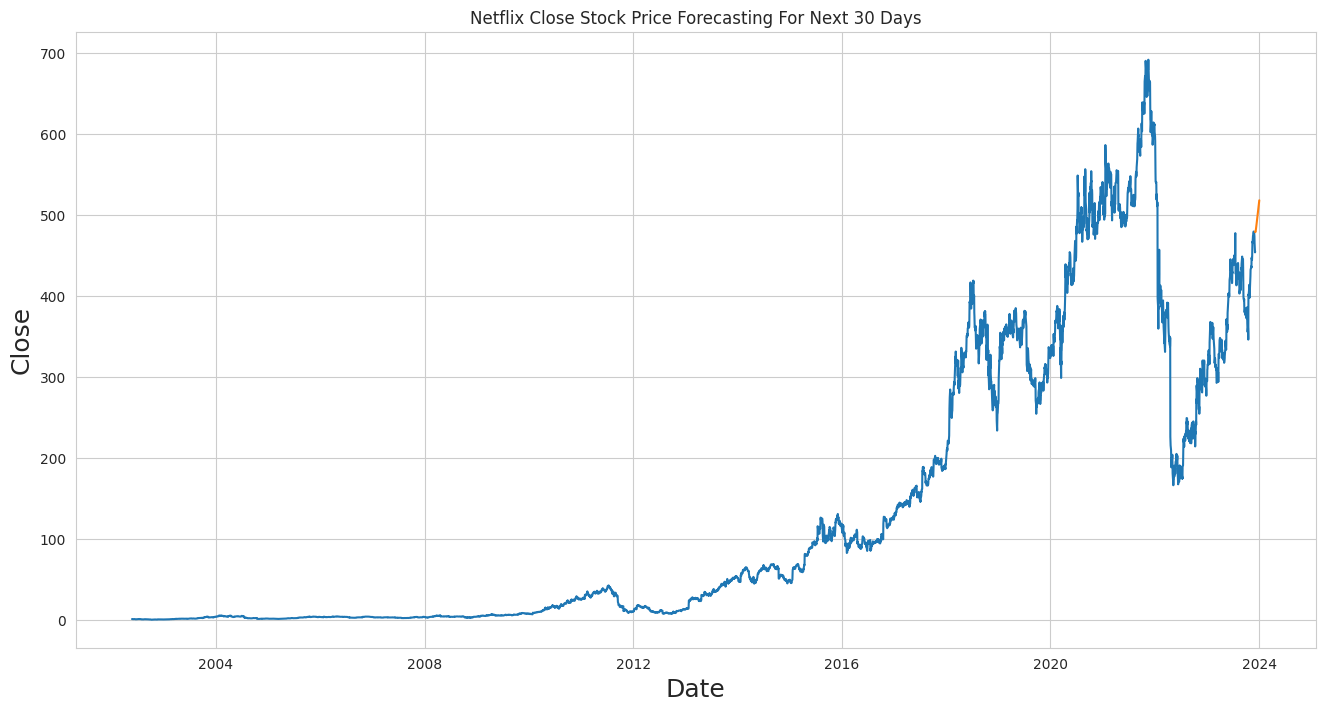

In [33]:
plt.figure(figsize=(16, 8))
plt.title('Netflix Close Stock Price Forecasting For Next 30 Days')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close' ,fontsize=18)
plt.plot(df['Close'])
plt.plot(df_result.set_index('Date')[['Forecasted']])

Thank You

If you found this notebook good enough, please upvote it..